<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Atomistic_Curie_Temp_Simulator_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cupy-cuda12x

!nvcc --version

!nvidia-smi

import cupy as cp
import numpy as np

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Tue Nov 11 08:58:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8       

In [2]:
# Auto-install CuPy for Colab/ephemeral environments (optional helper cell)
import sys, subprocess, shutil

def ensure_cupy():
    try:
        import cupy as cp  # noqa: F401
        return
    except Exception:
        pass

    pkg = "cupy-cuda12x"
    if shutil.which("nvidia-smi"):
        out = subprocess.run(["nvidia-smi"], capture_output=True, text=True).stdout
        if "CUDA Version: 11" in out:
            pkg = "cupy-cuda11x"
    print(f"Installing {pkg} …")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

    import cupy as cp  # noqa: F401
    print("CuPy installed and importable.")

ensure_cupy()

GPU detected: NVIDIA L4

=== Micro-benchmark (ms per sweep) ===
  20×20×20: 2.65 ms/sweep   [GPU (rb vectorized)]
   8×8×8 : 2.66 ms/sweep   [GPU (rb vectorized)]

=== Planning to time budget ===
  Budget: 4.50 h  |  Estimated total: 0.13 h
  Nano vs Bulk: T=36, sweeps=(eq 300, meas 800)  → ~0.06 h
  Phase Diagram: L=[4, 6, 8, 10, 12, 14, 16, 20], T=20, sweeps=(eq 180, meas 420)  → ~0.07 h

=== Nano vs Bulk simulation ===
  T step 1/36  (T = 0.700)
  T step 7/36  (T = 0.906)
  T step 13/36  (T = 1.111)
  T step 19/36  (T = 1.317)
  T step 25/36  (T = 1.523)
  T step 31/36  (T = 1.729)
Simulation for lattice (8, 8, 8) finished in 114.13 s
  T step 1/36  (T = 0.700)
  T step 7/36  (T = 0.906)
  T step 13/36  (T = 1.111)
  T step 19/36  (T = 1.317)
  T step 25/36  (T = 1.523)
  T step 31/36  (T = 1.729)
Simulation for lattice (20, 20, 20) finished in 113.30 s

Estimated T_c (Nano): 1.454 [J/k_B]
Estimated T_c (Bulk): 1.489 [J/k_B]
Saved: curie_temp_simulation.png

=== Phase Diagram simula

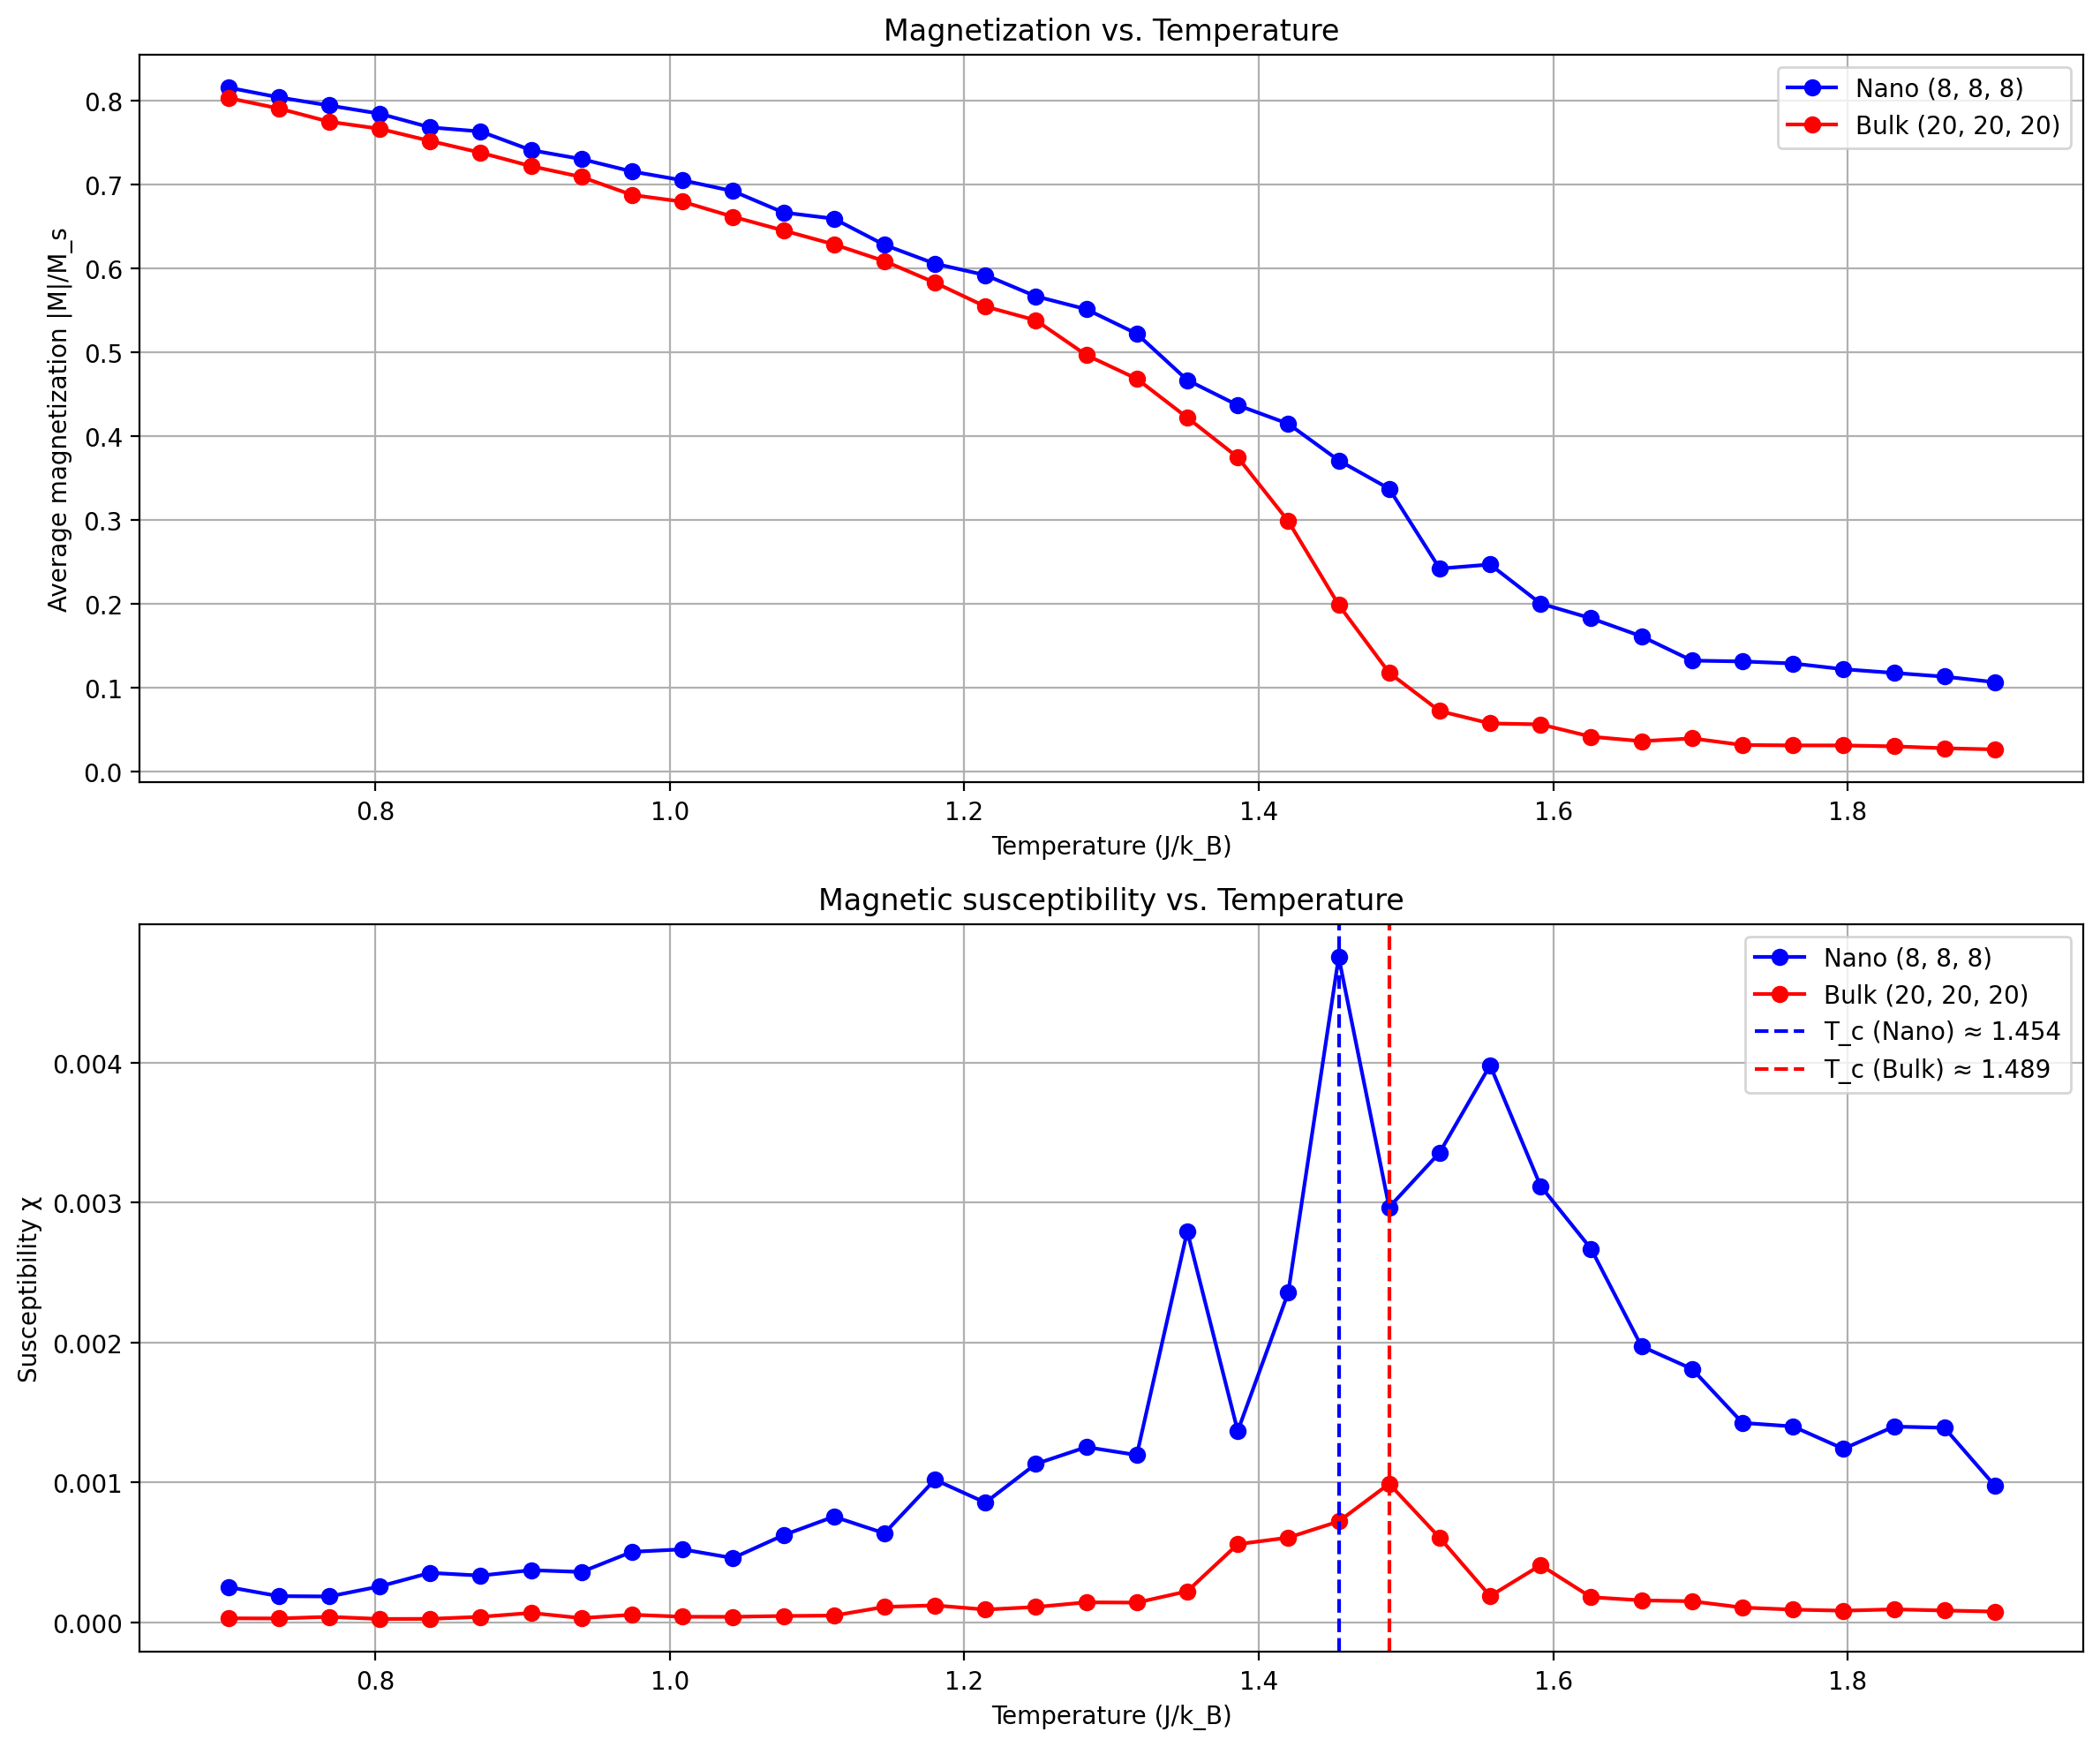

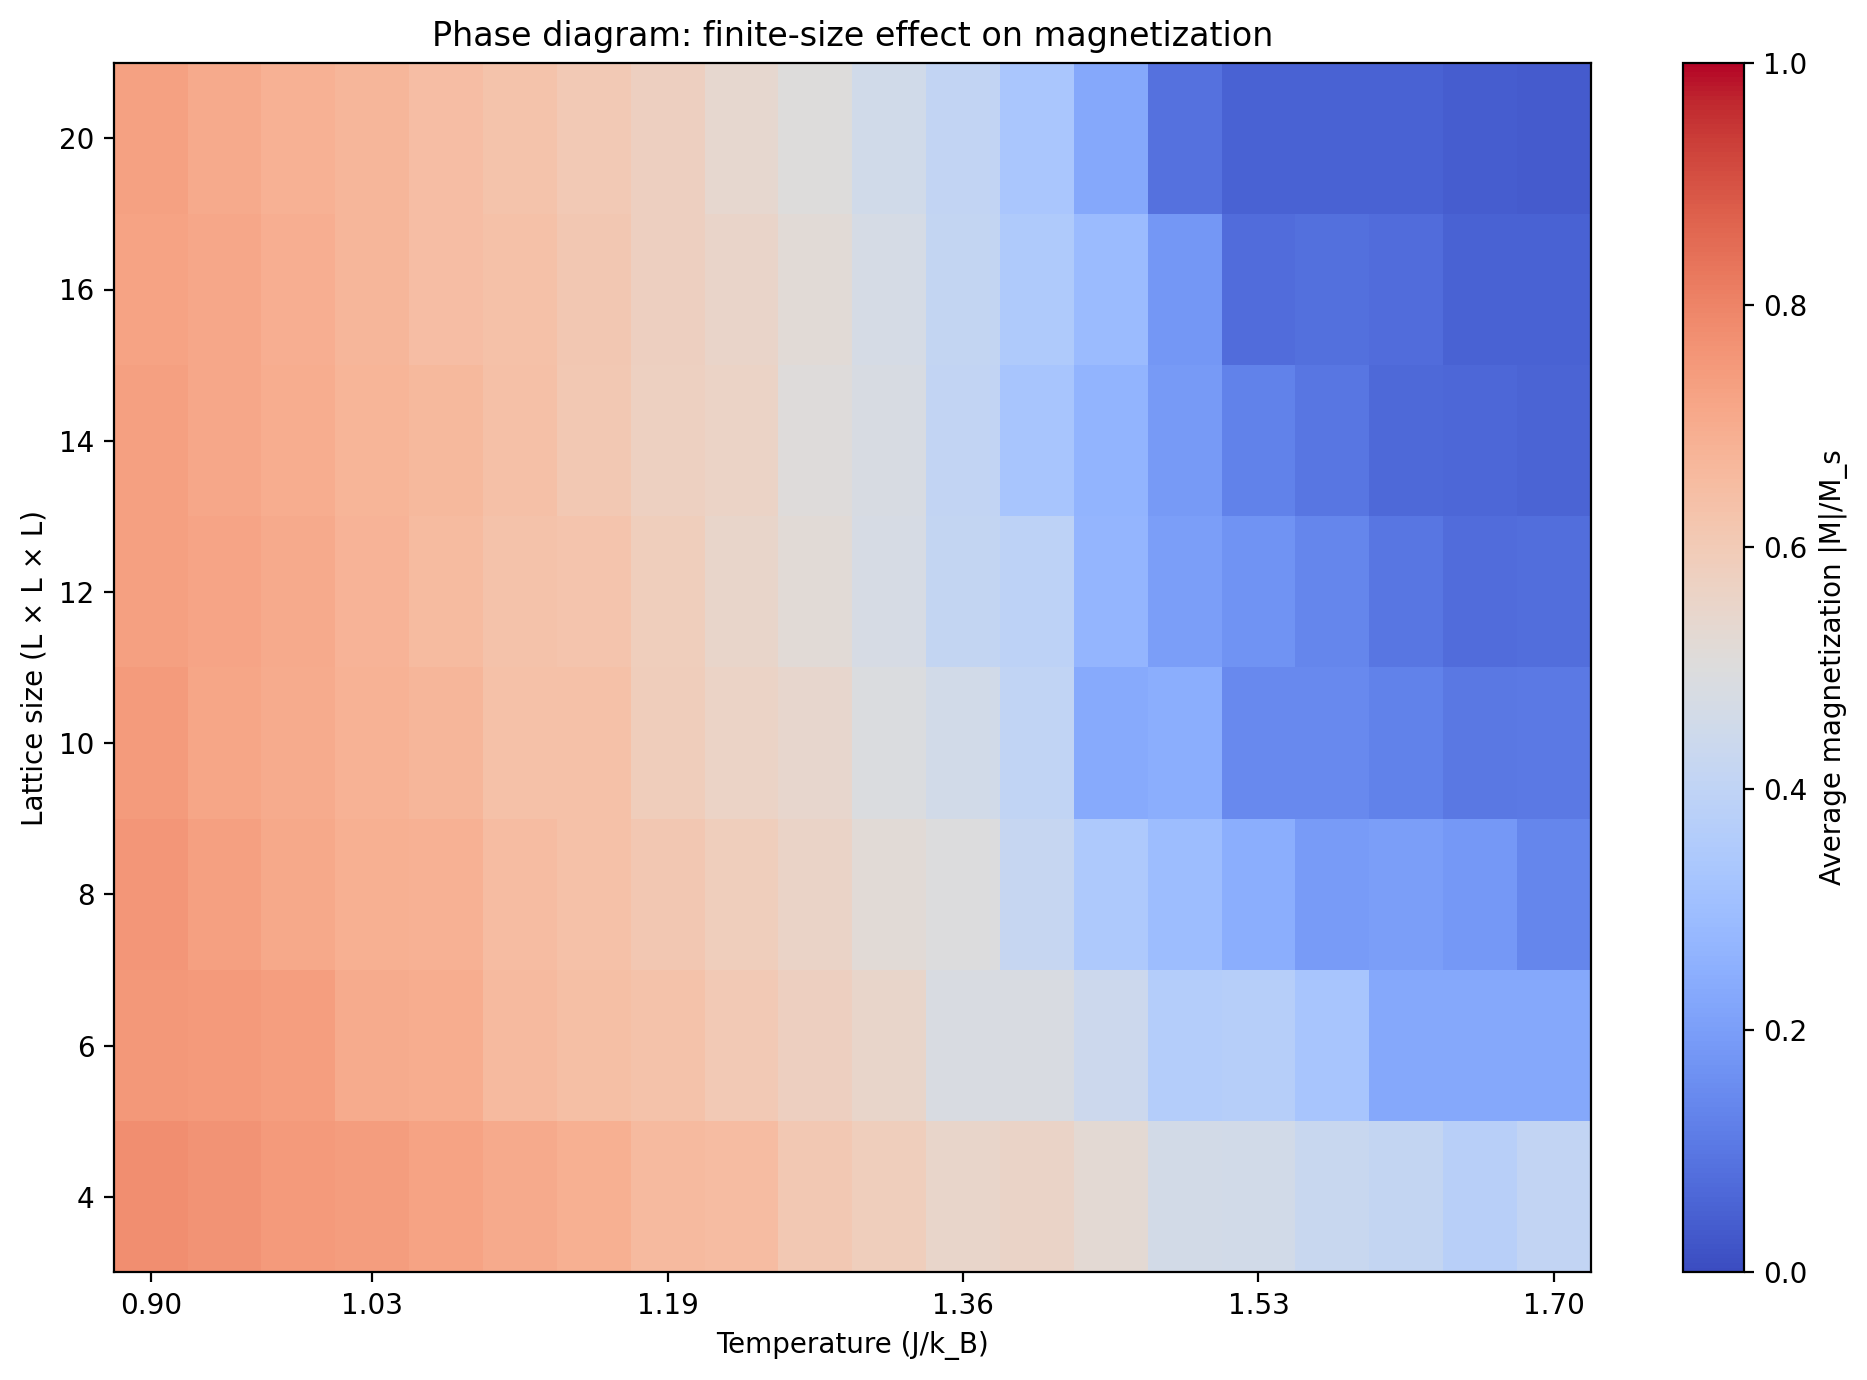

In [4]:
#!/usr/bin/env python
# -*- coding: ascii -*-

"""Atomistic Monte-Carlo (3-D Heisenberg) — budget-aware A100 edition.

Two studies:
1) Nano vs Bulk: extract T_c from susceptibility peaks.
2) Phase diagram: finite-size magnetization heat map (optional).

GPU via CuPy if available; CPU fallback via NumPy. Includes vectorized
red–black Metropolis updates for high throughput and a simple runtime model
to fit a user time budget.
"""

# PEP 8/257 compliant. Drop-in single cell for Colab/Jupyter or script use.
from __future__ import annotations

import math
import sys
import time
from typing import Dict, List, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt

# ============================== CONTROL KNOBS ===============================
TIME_BUDGET_HOURS: float = 4.5          # overall wall-time target (hours)
USE_VECTORIZED_GPU: bool = True         # True → red–black vectorized sweep on GPU
INCLUDE_PHASE_DIAGRAM: bool = True      # planner may disable to fit budget
SEED: int | None = 12345                # set to None for nondeterministic runs

# Temperature windows (reduced units J/k_B). Center loosely near Tc ~ 1.44.
T_RANGE_NVSBULK: Tuple[float, float] = (0.7, 1.9)   # nano vs bulk sweep
T_RANGE_PD: Tuple[float, float] = (0.9, 1.7)        # phase diagram sweep

# Initial (max) resolution; the planner will only scale these DOWN if needed.
N_T_NVSBULK_INIT: int = 36             # up to 36 temperatures
SWEEPS_EQ_NVSBULK_INIT: int = 300      # equilibration sweeps per T
SWEEPS_MEAS_NVSBULK_INIT: int = 800    # measurement sweeps per T

N_T_PD_INIT: int = 20                   # up to 20 temperatures for PD
SWEEPS_EQ_PD_INIT: int = 180            # PD equil sweeps per T
SWEEPS_MEAS_PD_INIT: int = 420          # PD meas sweeps per T
PD_L_SIZES: List[int] = [4, 6, 8, 10, 12, 14, 16, 20]  # planner may trim tail

# Floors so physics stays meaningful while fitting the budget.
MIN_T_NVSBULK: int = 16
MIN_T_PD: int = 10
MIN_SWEEPS_EQ: int = 100
MIN_SWEEPS_MEAS: int = 200
# ==========================================================================

# -------------------- CuPy import with graceful fallback -------------------
try:
    import cupy as cp  # type: ignore
    _GPU_AVAILABLE = True
except Exception:  # pragma: no cover
    import numpy as cp  # type: ignore
    _GPU_AVAILABLE = False
    print("CuPy not found – running on CPU with NumPy. Performance will be slower.")
    print("If you have an NVIDIA GPU, install CuPy and retry.", file=sys.stderr)

# Global matplotlib settings (once)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "sans-serif"

# -------------------------- Host-conversion helper --------------------------
def _to_host(arr):
    """Return a NumPy array regardless of backend (CuPy/NumPy/list)."""
    if isinstance(arr, list):
        return np.asarray(arr)
    try:
        return arr.get() if hasattr(arr, "get") else np.asarray(arr)
    except Exception:
        try:
            import cupy as _cp  # noqa: F401
            return _cp.asnumpy(arr)  # type: ignore[attr-defined]
        except Exception:
            return np.asarray(arr)

# ------------------------------ Util: parity cache --------------------------
_PARITY_CACHE: Dict[Tuple[int, int, int], Tuple[cp.ndarray, cp.ndarray]] = {}

def _get_parity_masks(shape: Tuple[int, int, int]) -> Tuple[cp.ndarray, cp.ndarray]:
    """Return boolean masks (even, odd) for red–black updates, cached by shape."""
    if shape in _PARITY_CACHE:
        return _PARITY_CACHE[shape]
    Nx, Ny, Nz = shape
    idx = cp.indices((Nx, Ny, Nz))
    even = (idx[0] + idx[1] + idx[2]) % 2 == 0
    odd = ~even
    _PARITY_CACHE[shape] = (even, odd)
    return even, odd

# ----------------------------- Neighbour sum (S) ----------------------------
def _neighbor_sum_full(spins: cp.ndarray) -> cp.ndarray:
    """Return neighbor sum S for the full lattice via periodic rolls."""
    return (
        cp.roll(spins, +1, axis=0) + cp.roll(spins, -1, axis=0) +
        cp.roll(spins, +1, axis=1) + cp.roll(spins, -1, axis=1) +
        cp.roll(spins, +1, axis=2) + cp.roll(spins, -1, axis=2)
    )

# ------------- Original scalar Metropolis (portable, slower) ----------------
def _metropolis_sweep_scalar(
    spins: cp.ndarray,
    temperature: float,
    J: float,
    k_B: float,
) -> cp.ndarray:
    """One sweep over all spins using the original per-spin loop (portable)."""
    Nx, Ny, Nz, _ = spins.shape
    num_spins = Nx * Ny * Nz

    rand_x = cp.random.randint(0, Nx, size=num_spins)
    rand_y = cp.random.randint(0, Ny, size=num_spins)
    rand_z = cp.random.randint(0, Nz, size=num_spins)
    new_spins = cp.random.randn(num_spins, 3)
    new_spins /= cp.linalg.norm(new_spins, axis=1, keepdims=True) + 1e-12
    rand_vals = cp.random.rand(num_spins)

    for i in range(num_spins):
        ix = int(rand_x[i]); iy = int(rand_y[i]); iz = int(rand_z[i])
        s_old = spins[ix, iy, iz]
        s_new = new_spins[i]

        xp = spins[(ix + 1) % Nx, iy, iz]
        xn = spins[(ix - 1) % Nx, iy, iz]
        yp = spins[ix, (iy + 1) % Ny, iz]
        yn = spins[ix, (iy - 1) % Ny, iz]
        zp = spins[ix, iy, (iz + 1) % Nz]
        zn = spins[ix, iy, (iz - 1) % Nz]
        neigh = xp + xn + yp + yn + zp + zn

        dE = float(-J * cp.dot(s_new - s_old, neigh))
        if (dE <= 0.0) or (float(rand_vals[i]) < math.exp(-dE / (k_B * temperature))):
            spins[ix, iy, iz] = s_new
    return spins

# -------------- Vectorized red–black sweep (GPU-friendly) -------------------
def _metropolis_sweep_rb(
    spins: cp.ndarray,
    temperature: float,
    J: float,
    k_B: float,
) -> cp.ndarray:
    """One red–black vectorized Metropolis sweep (two parity passes)."""
    Nx, Ny, Nz, _ = spins.shape
    even, odd = _get_parity_masks((Nx, Ny, Nz))

    for parity_mask in (even, odd):
        S = _neighbor_sum_full(spins)  # (Nx, Ny, Nz, 3)
        proposal = cp.random.randn(Nx, Ny, Nz, 3)
        proposal /= cp.linalg.norm(proposal, axis=3, keepdims=True) + 1e-12
        dE = -J * cp.sum((proposal - spins) * S, axis=3)  # (Nx, Ny, Nz)
        accept = (dE <= 0.0) | (cp.random.rand(Nx, Ny, Nz) < cp.exp(-dE / (k_B * temperature)))
        mask3 = parity_mask[..., None]
        spins = cp.where(mask3 & accept[..., None], proposal, spins)
    return spins

# ------------------------------- Dispatcher ---------------------------------
def metropolis_sweep(
    spins: cp.ndarray,
    temperature: float,
    J: float,
    k_B: float,
) -> cp.ndarray:
    """Dispatch to vectorized GPU sweep or scalar loop, per configuration."""
    if USE_VECTORIZED_GPU and _GPU_AVAILABLE:
        return _metropolis_sweep_rb(spins, temperature, J, k_B)
    return _metropolis_sweep_scalar(spins, temperature, J, k_B)

# ----------------------------- Simulation loops -----------------------------
def run_simulation(
    lattice_shape: Tuple[int, int, int],
    temperatures: cp.ndarray,
    J: float,
    k_B: float,
    n_steps_equil: int,
    n_steps_measure: int,
) -> Tuple[cp.ndarray, cp.ndarray]:
    """Run a full temperature sweep for one cubic lattice."""
    Nx, Ny, Nz = lattice_shape
    n_spins = Nx * Ny * Nz

    spins = cp.zeros((Nx, Ny, Nz, 3), dtype=cp.float32)
    spins[..., 2] = 1.0

    mag_vs_t: List[float] = []
    chi_vs_t: List[float] = []

    start = time.perf_counter()
    for idx, T in enumerate(temperatures):
        if idx % max(1, len(temperatures) // 6) == 0:
            print(f"  T step {idx + 1}/{len(temperatures)}  (T = {float(T):.3f})")

        for _ in range(n_steps_equil):
            spins = metropolis_sweep(spins, float(T), J, k_B)

        mags = cp.zeros(n_steps_measure, dtype=cp.float32)
        for mstep in range(n_steps_measure):
            spins = metropolis_sweep(spins, float(T), J, k_B)
            m_vec = cp.sum(spins, axis=(0, 1, 2))
            mags[mstep] = cp.linalg.norm(m_vec) / n_spins

        avg_m = cp.mean(mags)
        avg_m2 = cp.mean(mags ** 2)
        chi = (avg_m2 - avg_m ** 2) / (float(T) + 1e-9)

        mag_vs_t.append(float(avg_m))
        chi_vs_t.append(float(chi))

    elapsed = time.perf_counter() - start
    print(f"Simulation for lattice {lattice_shape} finished in {elapsed:.2f} s")

    return cp.array(mag_vs_t), cp.array(chi_vs_t)

# ------------------------------- Plotting -----------------------------------
def plot_nano_bulk(
    temps_cpu: Sequence[float],
    mag_nano: Sequence[float],
    chi_nano: Sequence[float],
    mag_bulk: Sequence[float],
    chi_bulk: Sequence[float],
    nano_shape: Tuple[int, int, int],
    bulk_shape: Tuple[int, int, int],
) -> None:
    """Create the magnetization and susceptibility plots for nano vs bulk."""
    t = np.asarray(temps_cpu, dtype=float)
    m_n = _to_host(mag_nano)
    m_b = _to_host(mag_bulk)
    c_n = _to_host(chi_nano)
    c_b = _to_host(chi_bulk)

    plt.figure(figsize=(12, 10))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t, m_n, "bo-", label=f"Nano {nano_shape}")
    ax1.plot(t, m_b, "ro-", label=f"Bulk {bulk_shape}")
    ax1.set_title("Magnetization vs. Temperature")
    ax1.set_xlabel("Temperature (J/k_B)")
    ax1.set_ylabel("Average magnetization |M|/M_s")
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(t, c_n, "bo-", label=f"Nano {nano_shape}")
    ax2.plot(t, c_b, "ro-", label=f"Bulk {bulk_shape}")
    ax2.set_title("Magnetic susceptibility vs. Temperature")
    ax2.set_xlabel("Temperature (J/k_B)")
    ax2.set_ylabel("Susceptibility χ")
    ax2.legend()
    ax2.grid(True)

    tc_nano = t[int(np.argmax(c_n))]
    tc_bulk = t[int(np.argmax(c_b))]
    print(f"\nEstimated T_c (Nano): {tc_nano:.3f} [J/k_B]")
    print(f"Estimated T_c (Bulk): {tc_bulk:.3f} [J/k_B]")

    ax2.axvline(tc_nano, color="blue", linestyle="--", label=f"T_c (Nano) ≈ {tc_nano:.3f}")
    ax2.axvline(tc_bulk, color="red", linestyle="--", label=f"T_c (Bulk) ≈ {tc_bulk:.3f}")
    ax2.legend()

    plt.tight_layout()
    plt.savefig("curie_temp_simulation.png")
    print("Saved: curie_temp_simulation.png")

def plot_phase_diagram(
    heatmap_data: cp.ndarray,
    lattice_sizes: Sequence[int],
    temps_cpu: Sequence[float],
) -> None:
    """Plot the phase diagram heat-map and save as PNG."""
    data = _to_host(heatmap_data)
    t = np.asarray(temps_cpu, dtype=float)

    plt.figure(figsize=(10, 7))
    plt.imshow(data, origin="lower", aspect="auto", cmap="coolwarm", vmin=0.0, vmax=1.0)
    cbar = plt.colorbar()
    cbar.set_label("Average magnetization |M|/M_s")

    plt.yticks(ticks=range(len(lattice_sizes)), labels=lattice_sizes)
    plt.ylabel("Lattice size (L × L × L)")

    n_ticks = min(6, len(t))
    tick_idx = np.linspace(0, len(t) - 1, n_ticks, dtype=int)  # NumPy for tick indices
    tick_labels = [f"{t[i]:.2f}" for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)
    plt.xlabel("Temperature (J/k_B)")

    plt.title("Phase diagram: finite-size effect on magnetization")
    plt.tight_layout()
    plt.savefig("Tc_phase_diagram_heatmap.png")
    print("Saved: Tc_phase_diagram_heatmap.png")

# ----------------------------- Phase-diagram core ---------------------------
def run_phase_diagram(
    lattice_sizes: Sequence[int],
    temperatures: cp.ndarray,
    J: float,
    k_B: float,
    n_steps_equil: int,
    n_steps_measure: int,
) -> cp.ndarray:
    """Return heat-map data: magnetization vs T for each lattice size."""
    curves = []
    for L in lattice_sizes:
        shape = (int(L), int(L), int(L))
        print(f"\nRunning lattice {L}×{L}×{L}")
        m_curve, _ = run_simulation(
            shape,
            temperatures,
            J,
            k_B,
            n_steps_equil=n_steps_equil,
            n_steps_measure=n_steps_measure,
        )
        curves.append(m_curve)
    return cp.array(curves)

# ---------------------------- Micro-benchmarking ----------------------------
def time_one_temp(
    lattice_shape: Tuple[int, int, int] = (20, 20, 20),
    T: float = 1.5,
    sweeps: int = 200,
) -> float:
    """Return milliseconds per sweep for the current backend.

    GPU: CUDA events (device time). CPU: perf_counter (wall time).
    """
    spins = cp.zeros((*lattice_shape, 3), dtype=cp.float32)
    spins[..., 2] = 1.0
    for _ in range(10):
        metropolis_sweep(spins, T, 1.0, 1.0)

    if _GPU_AVAILABLE and hasattr(cp, "cuda"):
        start_evt, stop_evt = cp.cuda.Event(), cp.cuda.Event()  # type: ignore[attr-defined]
        cp.cuda.Stream.null.synchronize()  # type: ignore[attr-defined]
        start_evt.record()
        for _ in range(sweeps):
            metropolis_sweep(spins, T, 1.0, 1.0)
        stop_evt.record()
        stop_evt.synchronize()
        ms_total = cp.cuda.get_elapsed_time(start_evt, stop_evt)  # type: ignore[attr-defined]
        return ms_total / sweeps
    else:
        t0 = time.perf_counter()
        for _ in range(sweeps):
            metropolis_sweep(spins, T, 1.0, 1.0)
        return (time.perf_counter() - t0) * 1000.0 / sweeps

# ------------------------------- Budget model -------------------------------
def _fit_ms_vs_L3(ms8: float, ms20: float) -> Tuple[float, float]:
    """Fit ms_per_sweep(L) ≈ c0 + c1 * L^3 from two points (L=8,20)."""
    L8, L20 = 8.0, 20.0
    N8, N20 = L8**3, L20**3
    c1 = (ms20 - ms8) / (N20 - N8)
    c0 = ms8 - c1 * N8
    return c0, c1

def _ms_for_L(L: int, c0: float, c1: float) -> float:
    """Predict ms_per_sweep for lattice size L via fitted model."""
    return max(0.0, c0 + c1 * (float(L) ** 3))

def estimate_seconds(
    ms8: float,
    ms20: float,
    n_t_nv: int,
    sweeps_eq_nv: int,
    sweeps_meas_nv: int,
    n_t_pd: int,
    sweeps_eq_pd: int,
    sweeps_meas_pd: int,
    pd_sizes: Sequence[int],
    include_pd: bool,
) -> Tuple[float, float, float]:
    """Return (secs_nano_bulk, secs_pd, secs_total) from ms/sweep model."""
    c0, c1 = _fit_ms_vs_L3(ms8, ms20)
    sweeps_nv = sweeps_eq_nv + sweeps_meas_nv
    sweeps_pd = sweeps_eq_pd + sweeps_meas_pd

    ms_nv = _ms_for_L(8, c0, c1) + _ms_for_L(20, c0, c1)
    secs_nv = (n_t_nv * sweeps_nv * ms_nv) / 1000.0

    secs_pd = 0.0
    if include_pd:
        ms_sum = sum(_ms_for_L(int(L), c0, c1) for L in pd_sizes)
        secs_pd = (n_t_pd * sweeps_pd * ms_sum) / 1000.0

    return secs_nv, secs_pd, secs_nv + secs_pd

def plan_to_budget(
    ms8: float,
    ms20: float,
    budget_hours: float,
    include_pd: bool,
) -> Tuple[int, int, int, int, int, int, List[int], bool]:
    """Shrink temps/sweeps/PD to fit budget. Returns planned knobs."""
    n_t_nv = N_T_NVSBULK_INIT
    swe_nv_e = SWEEPS_EQ_NVSBULK_INIT
    swe_nv_m = SWEEPS_MEAS_NVSBULK_INIT
    n_t_pd = N_T_PD_INIT
    swe_pd_e = SWEEPS_EQ_PD_INIT
    swe_pd_m = SWEEPS_MEAS_PD_INIT
    sizes = PD_L_SIZES.copy()
    use_pd = include_pd

    budget_secs = budget_hours * 3600.0

    def est_total() -> float:
        _, _, total = estimate_seconds(
            ms8, ms20, n_t_nv, swe_nv_e, swe_nv_m, n_t_pd, swe_pd_e, swe_pd_m, sizes, use_pd
        )
        return total

    # Greedy reductions: PD temps → PD sweeps → drop largest PD sizes → NV sweeps → NV temps → disable PD
    while est_total() > budget_secs:
        if use_pd and n_t_pd > MIN_T_PD:
            n_t_pd = max(MIN_T_PD, int(n_t_pd * 0.85)); continue
        if use_pd and (swe_pd_e > MIN_SWEEPS_EQ or swe_pd_m > MIN_SWEEPS_MEAS):
            swe_pd_e = max(MIN_SWEEPS_EQ, int(swe_pd_e * 0.9))
            swe_pd_m = max(MIN_SWEEPS_MEAS, int(swe_pd_m * 0.9)); continue
        if use_pd and len(sizes) > 5:
            sizes = sizes[:-1]; continue
        if swe_nv_e > MIN_SWEEPS_EQ or swe_nv_m > MIN_SWEEPS_MEAS:
            swe_nv_e = max(MIN_SWEEPS_EQ, int(swe_nv_e * 0.9))
            swe_nv_m = max(MIN_SWEEPS_MEAS, int(swe_nv_m * 0.9)); continue
        if n_t_nv > MIN_T_NVSBULK:
            n_t_nv = max(MIN_T_NVSBULK, int(n_t_nv * 0.9)); continue
        if use_pd:
            use_pd = False; continue
        break

    return n_t_nv, swe_nv_e, swe_nv_m, n_t_pd, swe_pd_e, swe_pd_m, sizes, use_pd

# ---------------------------------- Main ------------------------------------
def main() -> None:
    """Budget-aware orchestration: measure, plan, run, plot."""
    # Device info and RNG seeding
    if _GPU_AVAILABLE:
        try:
            dev_props = cp.cuda.runtime.getDeviceProperties(0)  # type: ignore[attr-defined]
            name = dev_props.get("name", "Unknown")
            if isinstance(name, (bytes, bytearray)):
                try:
                    name = name.decode("utf-8", errors="ignore")
                except Exception:
                    name = str(name)
            print(f"GPU detected: {name}")
        except Exception as exc:  # pragma: no cover
            print("GPU detection failed:", exc)
    else:
        print("Running on CPU (NumPy). Expect longer runtimes.")

    if SEED is not None:
        try:
            cp.random.seed(SEED)  # works for both CuPy and NumPy fallback
        except Exception:
            np.random.seed(SEED)

    # -------------------------- Micro-benchmarks ---------------------------
    print("\n=== Micro-benchmark (ms per sweep) ===")
    ms20 = time_one_temp(lattice_shape=(20, 20, 20), T=1.5, sweeps=120)
    ms8 = time_one_temp(lattice_shape=(8, 8, 8), T=1.5, sweeps=120)
    kind = (
        "GPU (rb vectorized)" if (USE_VECTORIZED_GPU and _GPU_AVAILABLE)
        else ("GPU (scalar)" if _GPU_AVAILABLE else "CPU")
    )
    print(f"  20×20×20: {ms20:.2f} ms/sweep   [{kind}]")
    print(f"   8×8×8 : {ms8:.2f} ms/sweep   [{kind}]")

    # ------------------------------ Plan ----------------------------------
    print("\n=== Planning to time budget ===")
    n_t_nv, swe_nv_e, swe_nv_m, n_t_pd, swe_pd_e, swe_pd_m, sizes, use_pd = plan_to_budget(
        ms8, ms20, TIME_BUDGET_HOURS, INCLUDE_PHASE_DIAGRAM
    )
    secs_nv, secs_pd, secs_tot = estimate_seconds(
        ms8, ms20, n_t_nv, swe_nv_e, swe_nv_m, n_t_pd, swe_pd_e, swe_pd_m, sizes, use_pd
    )
    print(f"  Budget: {TIME_BUDGET_HOURS:.2f} h  |  Estimated total: {secs_tot/3600:.2f} h")
    print(f"  Nano vs Bulk: T={n_t_nv}, sweeps=(eq {swe_nv_e}, meas {swe_nv_m})  → ~{secs_nv/3600:.2f} h")
    if use_pd:
        print(f"  Phase Diagram: L={sizes}, T={n_t_pd}, sweeps=(eq {swe_pd_e}, meas {swe_pd_m})  → ~{secs_pd/3600:.2f} h")
    else:
        print("  Phase Diagram: disabled to fit budget.")

    # ------------------------------ Run -----------------------------------
    J = 1.0
    k_B = 1.0

    # 1) Nano vs Bulk
    nano_shape = (8, 8, 8)
    bulk_shape = (20, 20, 20)
    temps_nv = cp.linspace(T_RANGE_NVSBULK[0], T_RANGE_NVSBULK[1], n_t_nv, dtype=cp.float32)
    temps_nv_cpu = [float(t) for t in temps_nv]

    print("\n=== Nano vs Bulk simulation ===")
    mag_nano, chi_nano = run_simulation(nano_shape, temps_nv, J, k_B, swe_nv_e, swe_nv_m)
    mag_bulk, chi_bulk = run_simulation(bulk_shape, temps_nv, J, k_B, swe_nv_e, swe_nv_m)
    plot_nano_bulk(temps_nv_cpu, mag_nano, chi_nano, mag_bulk, chi_bulk, nano_shape, bulk_shape)

    # 2) Phase diagram (optional)
    if use_pd:
        print("\n=== Phase Diagram simulation ===")
        temps_pd = cp.linspace(T_RANGE_PD[0], T_RANGE_PD[1], n_t_pd, dtype=cp.float32)
        heatmap = run_phase_diagram(sizes, temps_pd, J, k_B, swe_pd_e, swe_pd_m)
        plot_phase_diagram(heatmap, sizes, [float(t) for t in temps_pd])

# ------------------------------ Entry point ---------------------------------
if __name__ == "__main__":
    # In notebooks, avoid sys.exit cascades; just call main() and print exceptions.
    try:
        main()
    except Exception as exc:
        print("An unexpected error occurred:", exc, file=sys.stderr)